# Proyek Analisis Data: [Bike Sharing Dataset]
- **Nama:** Richie Rich Kennedy Zakaria
- **Email:** richie.zakaria100@gmail.com
- **ID Dicoding:** richie_rich100
- **Link** https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset/data

## Menentukan Pertanyaan Bisnis

- Pertanyaan 1
Bagaimana Tren Penggunaan Sepeda Berdasarkan Jam dalam Sehari?
- Pertanyaan 2
Apakah Ada Perbedaan Jumlah Penyewaan Sepeda Antara Hari Kerja dan Hari Libur ?

## Import Semua Packages/Library yang Digunakan

In [155]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Data Wrangling

### Gathering Data

Kami akan menggunakan dataset penyewaan sepeda per jam (hour.csv) yang berisi informasi terkait berbagai faktor cuaca, waktu, serta jumlah pengguna yang menyewa sepeda baik casual maupun terdaftar.

In [156]:
hour_df = pd.read_csv('./dataset/hour.csv')

**Insight:**
Dari temuan yang kami lihat dari data-data csv terdapat deskripsi dari kolom seperti: 
nsight: Dari hasil output di atas, kita dapat melihat beberapa kolom penting dalam dataset, seperti:

- instant: Nomor Urut dari Baris
- dteday: Tanggal dari Data yang diambil.
- season: Musim dalam bentuk angka interval (1 sampai 4) (1: musim semi, 2: musim panas, 3: musim gugur, 4: musim dingin).
- yr: Tahun, 0 untuk 2011 dan 1 untuk 2012. (2 tahun saja)
- mnth: Bulan dari 1 hingga 12.
- hr: Jam dalam format 24 jam.
- holiday: 1 jika hari tersebut libur, 0 jika bukan libur.
- weekday: Hari dalam minggu, di mana 0 = Minggu, 1 = Senin, dan seterusnya.
- workingday: 1 jika hari kerja (bukan libur), 0 jika tidak.
- weathersit: Kondisi cuaca dalam kode numerik (1 = cerah, 2 = fog, 3 = hujan ringan, 4 = hujan lebat).
- temp: Suhu aslinya dalam skala 0 hingga 1 (Format: 0.00 <= 0.XX >= 1.00)
- atemp: Suhu yang dirasakan oleh manusia.
- hum: Kelembapan dari skala 0 hingga 1.
- windspeed: Kecepatan angin dari skala 0 hingga 1.
- casual: Jumlah pengguna RENTAL sepeda casual (TIDAK ADA registrasi).
- registered: Jumlah pengguna RENTAL sepeda yang terdaftar
- cnt: Jumlah total penyewaan sepeda (dari yang casual / tanpa registrasi) dan yang teregistrasi

### Assessing Data

In [157]:
hour_df.info() # Jenis tipe field yang ada di dataset hour 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [158]:
missing_values = hour_df.isnull().sum()
missing_percentage = (missing_values / len(hour_df)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print("\nMissing Values Analysis:")
print(missing_info[missing_info['Missing Values'] > 0])


Missing Values Analysis:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


In [159]:
# Cek Data yang terduplikat
print("\nDuplicate Rows:", hour_df.duplicated().sum())


Duplicate Rows: 0


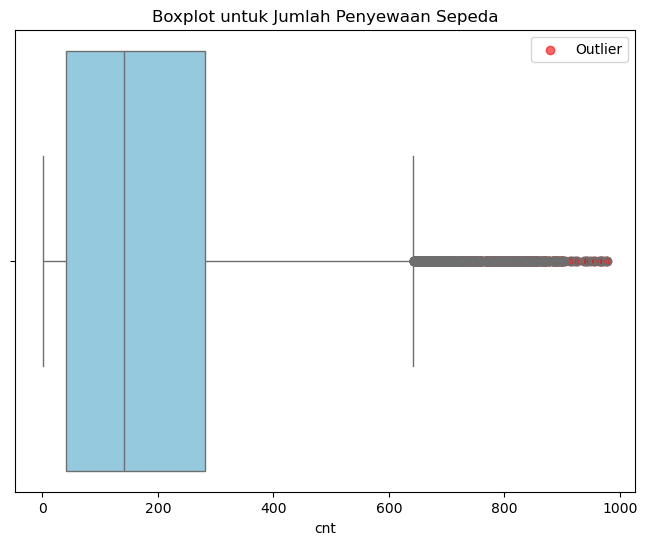

In [160]:
#CARI OUTLIER 

# Hitung IQR untuk menentukan outlier 
Q1 = hour_df['cnt'].quantile(0.25)
Q3 = hour_df['cnt'].quantile(0.75)
IQR = Q3 - Q1

# batas bawah dan atas untuk outlier
ambang_batas_min = Q1 - 1.5 * IQR
ambang_batas_max = Q3 + 1.5 * IQR

# Pisahkan outlier
outliers = hour_df[(hour_df['cnt'] > ambang_batas_max) | (hour_df['cnt'] < ambang_batas_min)]

# Buat boxplot untuk menampilkan apakah ada outlier
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x=hour_df['cnt'], color='skyblue')

# Tambahkan outlier akan ditandai sebagai titik titik merah (scatter plot red)
plt.scatter(outliers['cnt'], np.full_like(outliers['cnt'], 0), color='red', label='Outlier', alpha=0.6)

plt.legend()
plt.title('Boxplot untuk Jumlah Penyewaan Sepeda')
plt.show()


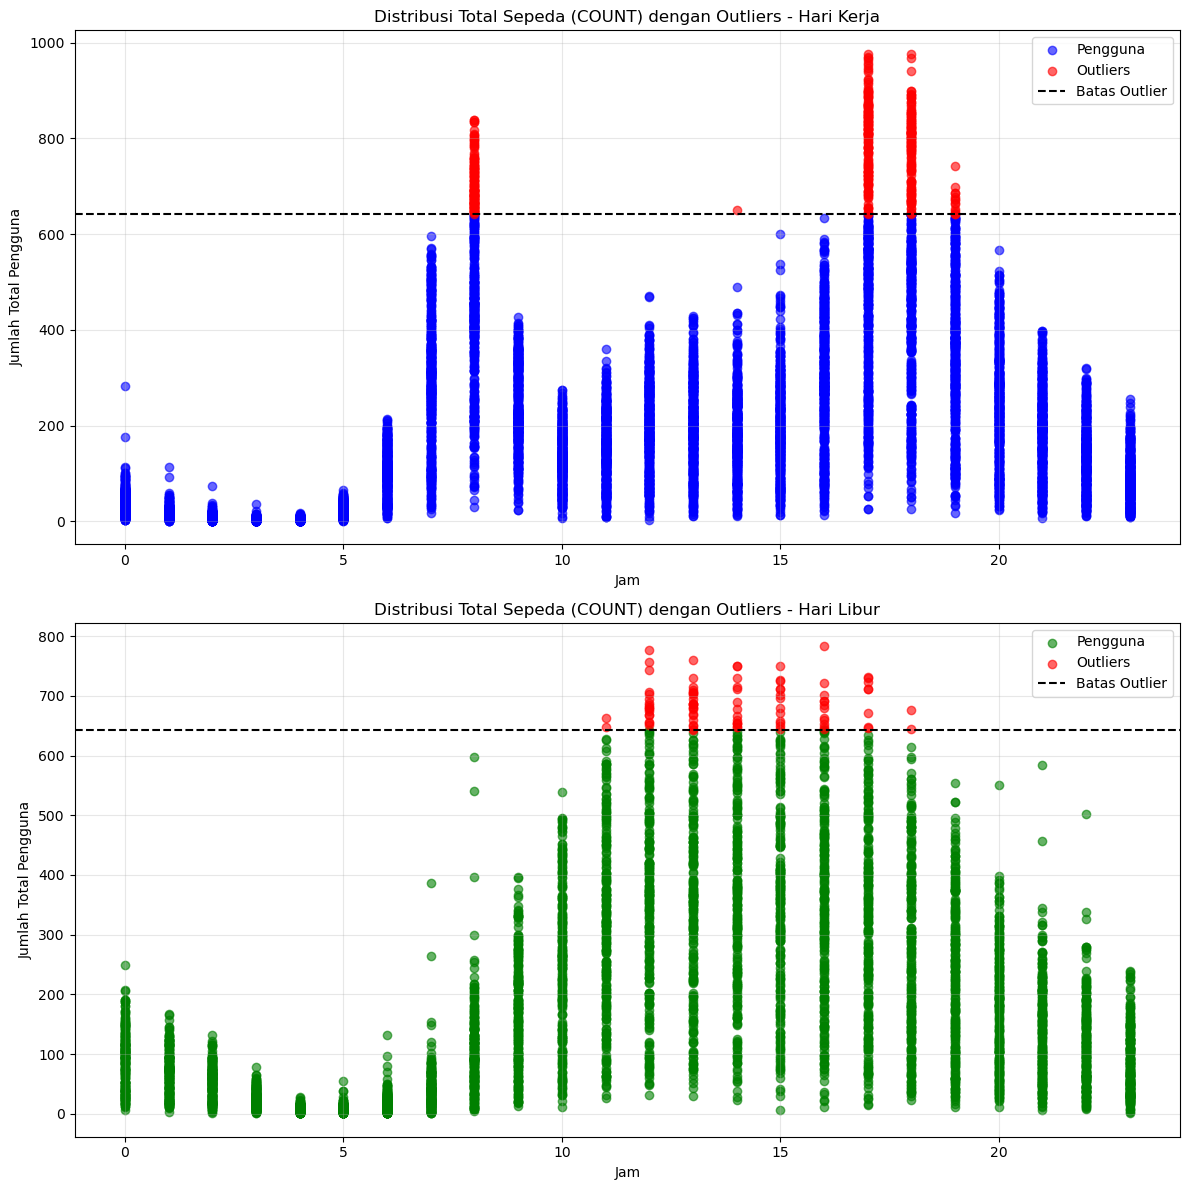


Informasi Outliers:
Total Jumlah outliers di hari kerja: 414
Total Jumlah outliers hari libur: 91
Batas outlier: 642.50


In [161]:
#ANALISA APAKAH OUTLIER TERSEBUT VALID ATAU TIDAK 
# Inisialisasi kedua subplot
fig, (kerja, libur) = plt.subplots(2, 1, figsize=(12, 12))

# Plot untuk Hari Kerja 
workday_data = hour_df[hour_df['workingday'] == 1]
workday_normal = workday_data[workday_data['cnt'] <= ambang_batas_max]
workday_outliers = workday_data[workday_data['cnt'] > ambang_batas_max]

kerja.scatter(workday_normal['hr'], 
           workday_normal['cnt'],
           c='blue', 
           label='Pengguna', 
           alpha=0.6)

kerja.scatter(workday_outliers['hr'], 
           workday_outliers['cnt'],
           c='red', 
           label='Outliers', 
           alpha=0.6)

kerja.axhline(y=ambang_batas_max, 
            color='black', 
            linestyle='--', 
            label='Batas Outlier')

kerja.set_title('Distribusi Total Sepeda (COUNT) dengan Outliers - Hari Kerja')
kerja.set_xlabel('Jam')
kerja.set_ylabel('Jumlah Total Pengguna')
kerja.grid(True, alpha=0.3)
kerja.legend()

# Plot untuk Hari Libur
holiday_data = hour_df[hour_df['workingday'] == 0]
holiday_normal = holiday_data[holiday_data['cnt'] <= ambang_batas_max]
holiday_outliers = holiday_data[holiday_data['cnt'] > ambang_batas_max]

libur.scatter(holiday_normal['hr'], 
           holiday_normal['cnt'],
           c='green', 
           label='Pengguna', 
           alpha=0.6)

libur.scatter(holiday_outliers['hr'], 
           holiday_outliers['cnt'],
           c='red', 
           label='Outliers', 
           alpha=0.6)

libur.axhline(y=ambang_batas_max, 
            color='black', 
            linestyle='--', 
            label='Batas Outlier')

libur.set_title('Distribusi Total Sepeda (COUNT) dengan Outliers - Hari Libur')
libur.set_xlabel('Jam')
libur.set_ylabel('Jumlah Total Pengguna')
libur.grid(True, alpha=0.3)
libur.legend()

plt.tight_layout()
plt.show()


print("\nInformasi Outliers:")
print(f"Total Jumlah outliers di hari kerja: {len(workday_outliers)}")
print(f"Total Jumlah outliers hari libur: {len(holiday_outliers)}")
print(f"Batas outlier: {ambang_batas_max:.2f}")

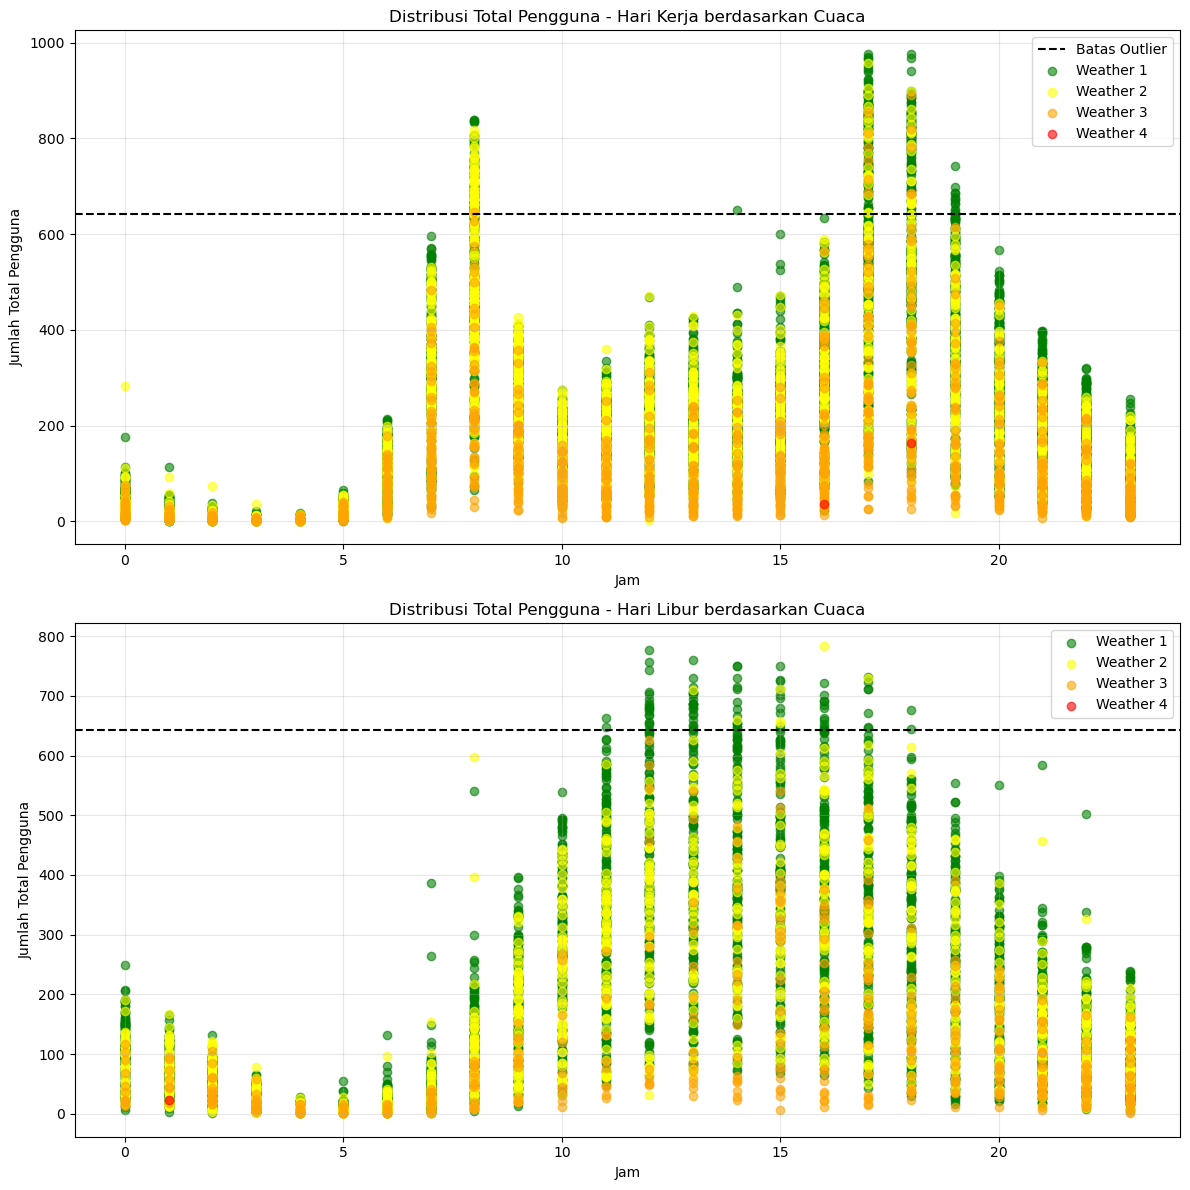


Keterangan Kondisi Cuaca:
Weather 1 (Green)  : Clear/Partly Cloudy
Weather 2 (Yellow) : Misty/Cloudy
Weather 3 (Orange) : Light Rain/Light Snow
Weather 4 (Red)    : Heavy Rain/Heavy Snow

Jumlah records untuk setiap kondisi cuaca:
weathersit
1    11413
2     4544
3     1419
4        3
Name: count, dtype: int64


In [162]:
# 2 Subplots di Initalize
fig, (kerja, libur) = plt.subplots(2, 1, figsize=(12, 12))

# Warna untuk menunjukkan cuaca
weather_colors = {
    1: 'green',    # Clear/Partly Cloudy
    2: 'yellow',   # Misty/Cloudy
    3: 'orange',   # Light Rain/Light Snow
    4: 'red'       # Heavy Rain/Heavy Snow
}

kerja.axhline(y=ambang_batas_max, 
            color='black', 
            linestyle='--', 
            label='Batas Outlier')

# Plot untuk Hari Kerja
workday_data = hour_df[hour_df['workingday'] == 1]

for weather in sorted(workday_data['weathersit'].unique()):
    weather_mask = workday_data['weathersit'] == weather
    kerja.scatter(workday_data[weather_mask]['hr'], 
                workday_data[weather_mask]['cnt'],
                c=weather_colors[weather], 
                label=f'Weather {weather}', 
                alpha=0.6)

kerja.set_title('Distribusi Total Pengguna - Hari Kerja berdasarkan Cuaca')
kerja.set_xlabel('Jam')
kerja.set_ylabel('Jumlah Total Pengguna')
kerja.grid(True, alpha=0.3)
kerja.legend()

# Plot untuk Hari Libur 

holiday_data = hour_df[hour_df['workingday'] == 0]

for weather in sorted(holiday_data['weathersit'].unique()):
    weather_mask = holiday_data['weathersit'] == weather
    libur.scatter(holiday_data[weather_mask]['hr'], 
                holiday_data[weather_mask]['cnt'],
                c=weather_colors[weather], 
                label=f'Weather {weather}', 
                alpha=0.6)

libur.set_title('Distribusi Total Pengguna - Hari Libur berdasarkan Cuaca')
libur.set_xlabel('Jam')
libur.set_ylabel('Jumlah Total Pengguna')
libur.grid(True, alpha=0.3)
libur.legend()

libur.axhline(y=ambang_batas_max, 
            color='black', 
            linestyle='--', 
            label='Batas Outlier')


plt.tight_layout()
plt.show()

# Keterangan Kondisi Cuaca
print("\nKeterangan Kondisi Cuaca:")
print("Weather 1 (Green)  : Clear/Partly Cloudy")
print("Weather 2 (Yellow) : Misty/Cloudy")
print("Weather 3 (Orange) : Light Rain/Light Snow")
print("Weather 4 (Red)    : Heavy Rain/Heavy Snow")

# Jumalah Rekaman Cuaca
print("\nJumlah records untuk setiap kondisi cuaca:")
print(hour_df['weathersit'].value_counts().sort_index())

**Keterangan**
Visualisasi ini menampilkan distribusi total pengguna sepeda berdasarkan kondisi cuaca, dibedakan antara hari kerja dan hari libur. Garis putus-putus hitam menandakan batas outlier.

**Kode Implementasi**
Visualisasi menggunakan matplotlib dan pandas dengan pembagian subplot untuk hari kerja dan hari libur.

**Warna Cuaca**
- **Hijau (Weather 1)**: Cerah/Berawan Sebagian
- **Kuning (Weather 2)**: Berkabut/Berawan
- **Oranye (Weather 3)**: Hujan Ringan/Salju Ringan
- **Merah (Weather 4)**: Hujan Lebat/Salju Lebat

**Kesimpulan**
1. Cuaca memiliki pengaruh signifikan terhadap penggunaan sepeda
2. Pola penggunaan berbeda antara hari kerja dan hari libur
3. Cuaca cerah menghasilkan penggunaan tertinggi di kedua tipe hari

**Technical Notes**
- Alpha 0.6 digunakan untuk transparansi titik
- Grid dengan alpha 0.3 untuk memudahkan pembacaan
- Batas outlier ditandai dengan garis hitam putus-putus

**Insight:**
- Dataset memiliki 17379 entries dan 17 kolom 
- Setelah dicek secara rinci, dataset tidak memiliki nilai yang null
- Dataset ini juga tidak memiliki baris duplikat

**Tipe-Tipe Data**
- Terdapat 12 Kolom yang menggunakan int64 (instant, season, yr, mnth, hr, holiday, weekday, workingday, weathersit)
- Terdapat 4 Kolom yang menggunakan tipe data float64 (temp, atemp, hum, windspeed)
- Kolom objek: Kolom dteday adalah tipe object (string) yang sebenarnya adalah datetime atau tanggal

**Data Range**
Dataset tersebar dari Januari 2011 sampai dengan Oktober 2012

**Outliers**
- Terdapat Outliers dalam cnt (jumlah sepeda casual dan yang teregistrasi) ada rentang diarea 900 hingga 1000 
- Di hari Kerja (Area Jam 8) Outlier mulai melewati ambang batas max, ini valid dikarenakan dengan adanya jam pagi yang merupakan jam berangkat kerja bisa membuat para pengguna sepeda mulai menyewa sepeda untuk bertransportasi, begitupun juga dengan area sore (Area Pukul 16:00-19:00) merupakan jam pulang kerja. 
- Uniknya di hari kerja jam 2, outlier mulai menunjukkan adanya kenaikan secara signifikan, tetap terhitung valid karena jam 2 terhitung sebagai jam break (jam area makan siang para pekerja) sehingga tidak perlu dilakukan cleaning.
- Di hari Libur juga dikatakan valid dikarenakan dengan adanya tidak ada aktifitas maka para persepeda mengisi aktifitasnya dengan bersepeda menggunakan sepeda sewa. Cuaca pun juga bisa menjadi faktor mengapa Outlier ini bisa menjadi Valid.


### Cleaning Data

## SUDAH BERSIH

**Insight:**
- Terdapat 15,720 dari 17,379 rekaman yang memiliki complete hours (24 jam hourly entries) tetapi tidak diharuskan 24 jam atau memiliki 24 entries dalam 1 date ( 1 hari ) sehingga tidak ada mandatory untuk melakukan cleaning.
- Dikarenakan outlier-outlier valid maka tidak perlu adanya cleaning. 

## Exploratory Data Analysis (EDA)

### Explore ...

In [163]:
# Statistik deskriptif dasar
print("Statistik Deskriptif:")
print(hour_df.describe())

# Informasi dataset
print("\nInformasi Dataset:")
print(hour_df.info())

# Statistik Waktu
print("Distribusi Waktu:")
print(f"- Total jam: {len(hour_df)} records")
print(f"- Range bulan: 1-{hour_df['mnth'].max()}")
print(f"- Range jam: {hour_df['hr'].min()}-{hour_df['hr'].max()}")

Statistik Deskriptif:
          instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431

**Insight:**
- Data mencakup 2 tahun (2011-2012)
- Distribusi jam dari 0 sampai 23 jam
- Temperature Rata-rata 0.49 (49 derajat Celsius)


## Visualization & Explanatory Analysis

### Pertanyaan 1: Bagaimana Tren Penggunaan Sepeda Berdasarkan Jam dalam Sehari?

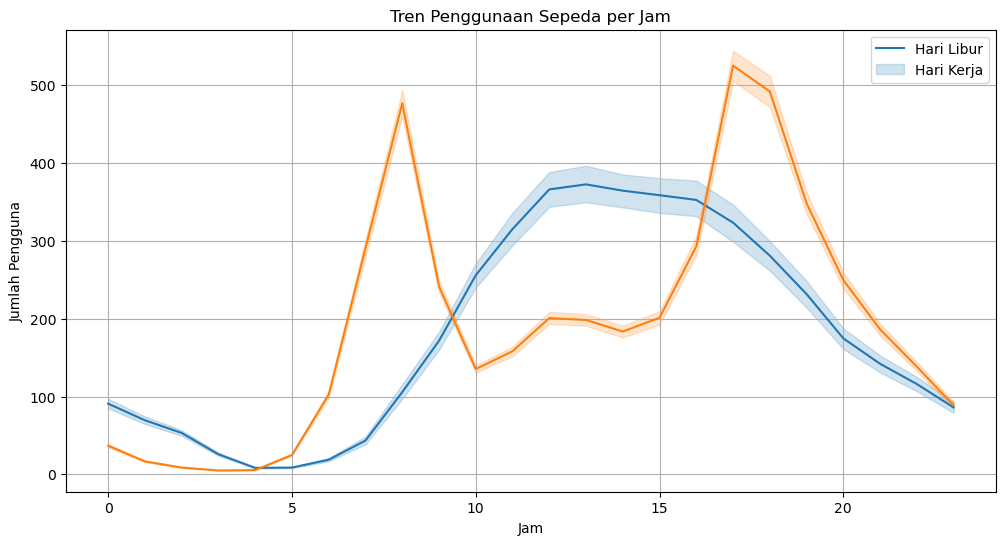

Jam tersibuk: 17:00 dengan rata-rata 461.45 pengguna
Pengunjung Terbanyak: 495


In [164]:
# Analisis tren per jam
plt.figure(figsize=(12, 6))
sns.lineplot(data=hour_df, x='hr', y='cnt', hue='workingday')
plt.title('Tren Penggunaan Sepeda per Jam')
plt.xlabel('Jam')
plt.ylabel('Jumlah Pengguna')
plt.legend(['Hari Libur', 'Hari Kerja'])
plt.grid(True)
plt.show()

# Analisis jam tersibuk
hourly_avg = hour_df.groupby('hr')['cnt'].mean()
hourly_mode = hour_df.groupby('hr')['cnt'].agg(lambda x: x.value_counts().index[0])
peak_hour = hourly_avg.idxmax()
peak_bicyclers = hourly_mode.max()
print(f"Jam tersibuk: {peak_hour}:00 dengan rata-rata {hourly_avg[peak_hour]:.2f} pengguna")
print(f"Pengunjung Terbanyak: {hourly_mode[peak_hour]}")



Musim Spring:
Jam tersibuk: 17:00 dengan rata-rata 263.98 pengguna


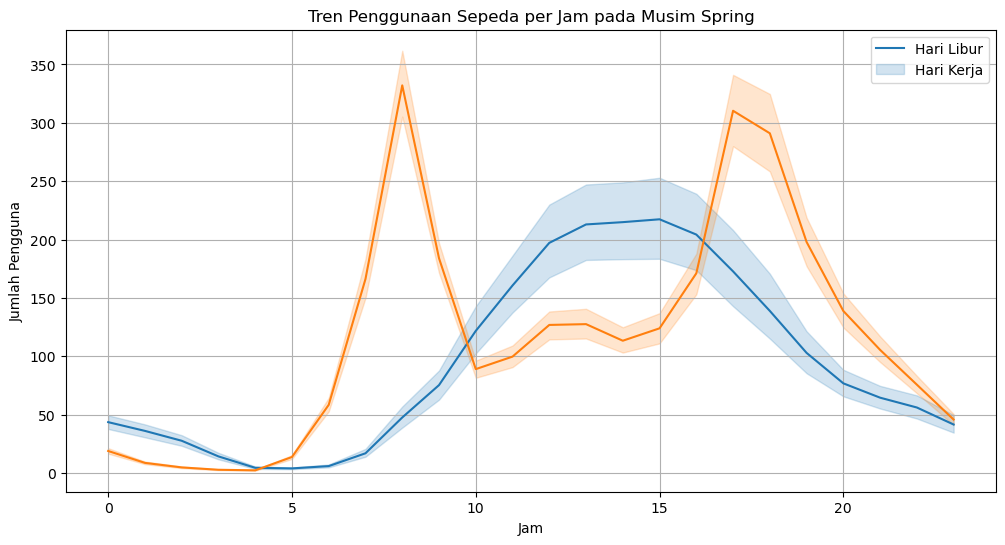


Musim Summer:
Jam tersibuk: 17:00 dengan rata-rata 518.85 pengguna


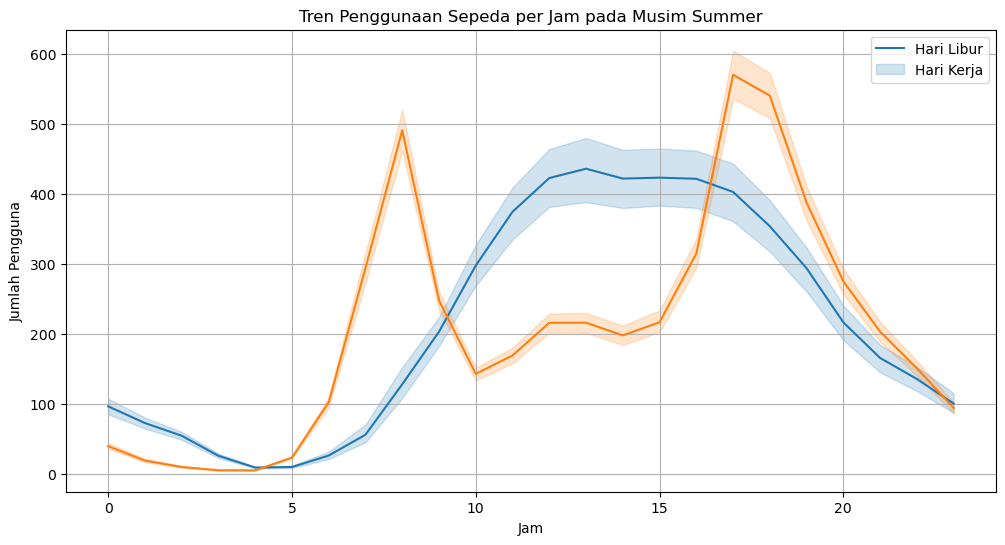


Musim Fall:
Jam tersibuk: 17:00 dengan rata-rata 572.14 pengguna


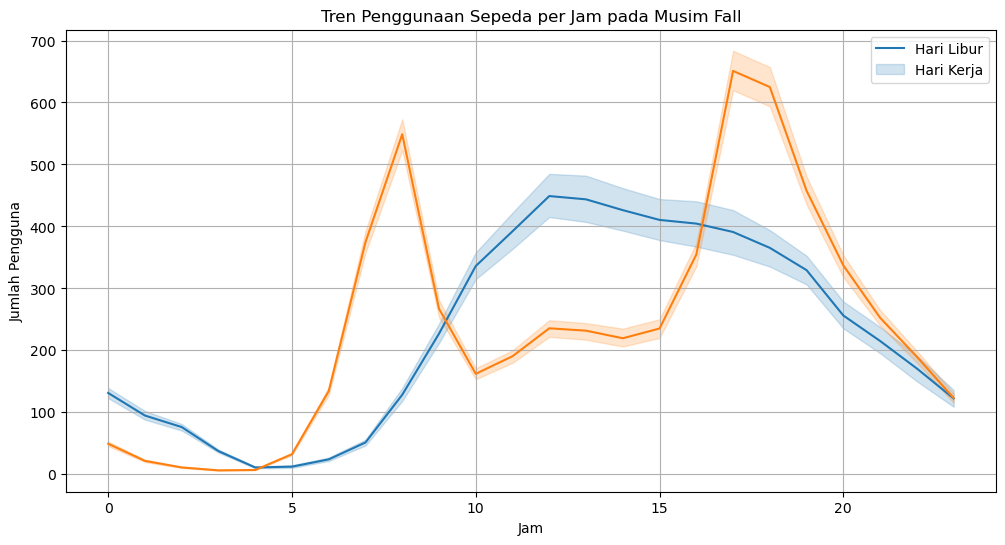


Musim Winter:
Jam tersibuk: 17:00 dengan rata-rata 486.16 pengguna


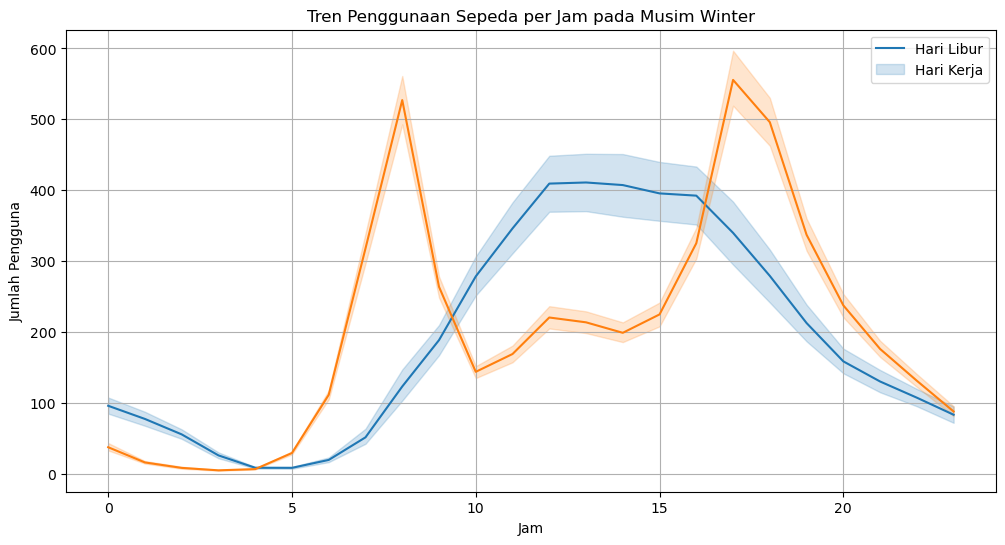

In [165]:
# Season Information (Dictionary)
seasons = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}

# Inisialisasi plot untuk setiap musim
for season_num in seasons.keys():
    # Data di filter untuk menyesuaikan dengan setiap season
    season_data = hour_df[hour_df['season'] == season_num]
    
    # Buat plot individu melalui for range seaborn
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=season_data, 
        x='hr', 
        y='cnt', 
        hue='workingday'
    )
    
    # Plot Title, Labels, Legend, dan Grid
    plt.title(f'Tren Penggunaan Sepeda per Jam pada Musim {seasons[season_num]}')
    plt.xlabel('Jam')
    plt.ylabel('Jumlah Pengguna')
    plt.legend(['Hari Libur', 'Hari Kerja'])
    plt.grid(True)
    
    # Kalkulasi rata-rata per jam dan jam tersibuk
    season_hour_avg = season_data.groupby('hr')['cnt'].mean() 
    peak_hour = season_hour_avg.idxmax()
    print(f"\nMusim {seasons[season_num]}:")
    print(f"Jam tersibuk: {peak_hour}:00 dengan rata-rata {season_hour_avg[peak_hour]:.2f} pengguna")
    
    plt.show()

# Insight Jawaban Nomor 1

- Tren ini mengonfirmasi bahwa adanya penggunaan sepeda sewa di hari kerja lebih dipagi hari berhubungan dengan pergi ke kantor/sekolah, sedangkan di hari libur lebih banyak digunakan untuk rekreasi atau aktivitas santai.
- Puncak penggunaan sepeda di sore hari cukup tinggi di kedua jenis hari, menunjukkan bahwa banyak orang tetap menggunakan sepeda sebagai moda transportasi di sore hari baik saat bekerja maupun berlibur.
- Penggunaan Trend tiap jam di Musim-musim berbeda tetap menunjukkan pattern yang sama namun yang membedakan adalah volume pemakaian sepeda tersebut.


## Analisa Grafik ## 



### Pertanyaan 2: Apakah Ada Perbedaan Jumlah Penyewaan Sepeda Antara Hari Kerja dan Hari Libur ?

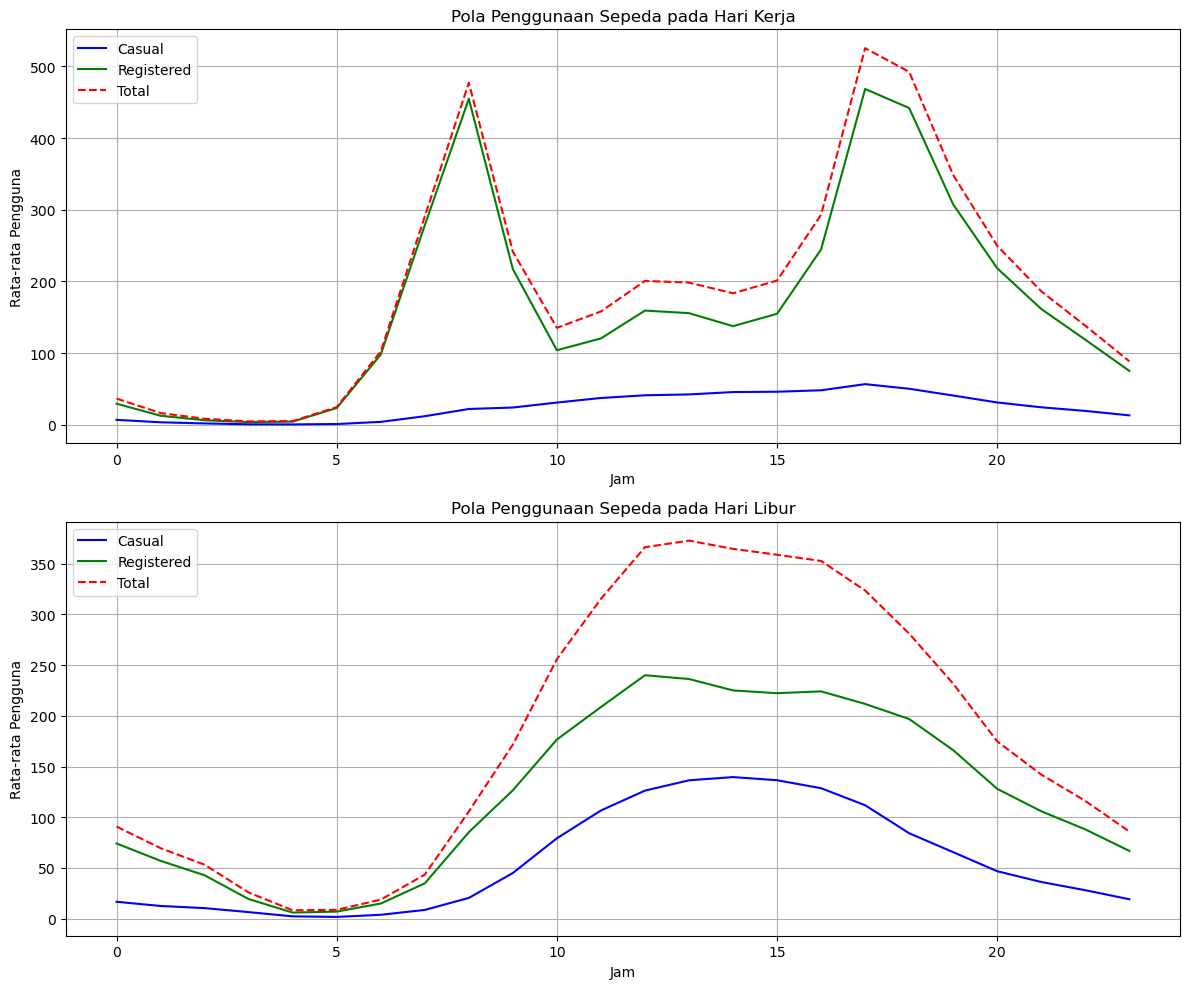

In [166]:
# Analisis detail per tipe hari dan jam
hourly_by_workday = hour_df.groupby(['workingday', 'hr'])[['casual', 'registered', 'cnt']].mean()

# Plot untuk membandingkan pola harian
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot untuk hari kerja
hourly_by_workday.loc[1]['casual'].plot(ax=ax1, color='blue', label='Casual')
hourly_by_workday.loc[1]['registered'].plot(ax=ax1, color='green', label='Registered')
hourly_by_workday.loc[1]['cnt'].plot(ax=ax1, color='red', linestyle='--', label='Total')
ax1.set_title('Pola Penggunaan Sepeda pada Hari Kerja')
ax1.set_xlabel('Jam')
ax1.set_ylabel('Rata-rata Pengguna')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plot untuk hari libur
hourly_by_workday.loc[0]['casual'].plot(ax=ax2, color='blue', label='Casual')
hourly_by_workday.loc[0]['registered'].plot(ax=ax2, color='green', label='Registered')
hourly_by_workday.loc[0]['cnt'].plot(ax=ax2, color='red', linestyle='--', label='Total')
ax2.set_title('Pola Penggunaan Sepeda pada Hari Libur')
ax2.set_xlabel('Jam')
ax2.set_ylabel('Rata-rata Pengguna')
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

**Insight:**
1. Penggunaan Hari Kerja
- **Peak Volume**: Mencapai maksimum tertinggi pada jam-jam sibuk
- **Distribusi**: Tidak merata sepanjang hari
  - Pagi (07:00-09:00): Peak pertama 
  - Sore (17:00-19:00): Peak kedua
2. Penggunaan Hari Libur
- **Distribusi**: Lebih merata dan konsisten
  - Mulai meningkat: 10:00 pagi
  - Tetap tinggi hingga: 17:00 sore
- **Volume**: Lebih rendah dari hari kerja
- **Durasi**: Periode penggunaan aktif lebih panjang

3. Perbandingan Karakteristik
    Hari Kerja:
- Volume tinggi tapi tidak stabil
- Pola penggunaan predictable
- Fokus pada commuting

    Hari Libur:
- Volume lebih rendah tapi stabil
- Distribusi lebih merata
- Dominan penggunaan rekreasional


## Analisis Lanjutan (Opsional)

C:\Users\User\AppData\Local\Temp\ipykernel_9168\2504997127.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weather_time_clusters = hour_df.groupby(['time_period', 'weathersit'])['cnt'].agg([



Weather-Time Cluster Analysis:
                          mean  count     std
time_period weathersit                       
Subuh 0-6   1            29.14   2796   37.95
            2            30.24   1153   38.63
            3            18.94    325   28.60
            4            23.00      1     NaN
Pagi 7-12   1           252.50   2646  164.87
            2           234.96   1380  157.31
            3           131.28    337  121.16
            4              NaN      0     NaN
Siang 13-18 1           356.10   2939  199.31
            2           286.77   1035  177.67
            3           186.73    399  171.50
            4           100.00      2   90.51
Malam 19-24 1           201.76   2543  134.85
            2           165.99    791  114.89
            3           104.47    306   97.35
            4              NaN      0     NaN


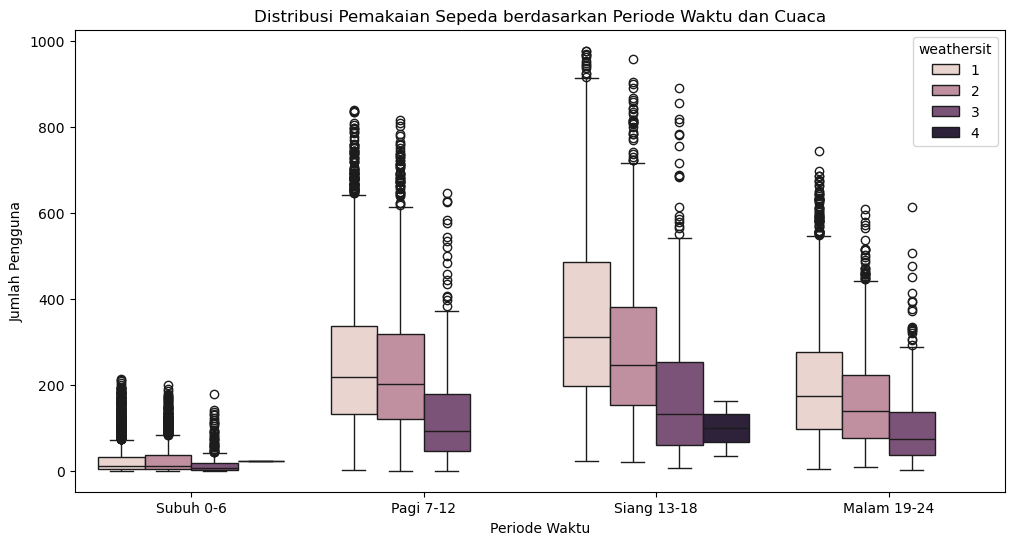


Keterangan Cluster:
Weather 1 (Pink)  : Clear/Partly Cloudy
Weather 2 (Lavender) : Misty/Cloudy
Weather 3 (Purple) : Light Rain/Light Snow
Weather 4 (Dark Purple)    : Heavy Rain/Heavy Snow


In [167]:
# ANALISIS LANJUTAN CUACA DAN WAKTU CLUSTERING 
# Create time periods
hour_df['time_period'] = pd.cut(hour_df['hr'], 
                               bins=[0, 6, 12, 18, 24],
                               labels=['Subuh 0-6', 'Pagi 7-12', 'Siang 13-18', 'Malam 19-24']) #Pengelompokan berbasis kategori jam (Categorical)

# Membuat Cluster Pengelompokan Data berdasarkan Periode Waktu dan Cuaca
weather_time_clusters = hour_df.groupby(['time_period', 'weathersit'])['cnt'].agg([
    'mean',
    'count',
    'std'
]).round(2)

print("\nWeather-Time Cluster Analysis:")
print(weather_time_clusters)

# Cluster Visualisasi Pengelompokan Data basis dari Periode Waktu dan Cuaca
plt.figure(figsize=(12, 6))
sns.boxplot(data=hour_df, x='time_period', y='cnt', hue='weathersit')
plt.title('Distribusi Pemakaian Sepeda berdasarkan Periode Waktu dan Cuaca')
plt.xlabel('Periode Waktu')
plt.ylabel('Jumlah Pengguna')
plt.show()

print("\nKeterangan Cluster:")
print("Weather 1 (Pink)  : Clear/Partly Cloudy")
print("Weather 2 (Lavender) : Misty/Cloudy")
print("Weather 3 (Purple) : Light Rain/Light Snow")
print("Weather 4 (Dark Purple)    : Heavy Rain/Heavy Snow")

**Periode Waktu vs Jumlah Pengguna**

Pagi (7-12) dan Siang (13-18) memiliki jumlah pemakaian sepeda tertinggi dibanding periode lainnya sedangkan Subuh memiliki jumlah pengguna terendah.
Malam (19-24) memiliki jumlah pengguna lebih banyak dibanding subuh tetapi masih lebih rendah dari siang dan pagi.
Pengaruh Cuaca terhadap Pemakaian Sepeda

Semakin berat hujan akan semakin dikit para pengguna sepeda sewa untuk bertransportasi. Alasan ini logis karena orang-orang rentan tidak ingin terkena hujan karena takut basah. 

## Conclusion

## Conclution pertanyaan 1
 Hari Kerja:
- Peak hours teridentifikasi pada pagi (07:00-09:00) dan sore (17:00-19:00)
- Volume penggunaan lebih tinggi dan terpola
- Dominan digunakan untuk komuting (kantor/sekolah)

 Hari Libur:
- Distribusi lebih merata sepanjang 10:00-17:00
- Volume lebih rendah namun lebih stabil
- Dominan digunakan untuk aktivitas rekreasional

Volume penggunaan sepeda tertinggi pada Musim Gugur


## Conclution pertanyaan 2

## Conclution pertanyaan 2
 Hari Kerja:
- Peak hours teridentifikasi pada pagi (07:00-09:00) dan sore (17:00-19:00)
- Volume penggunaan lebih tinggi dan terpola
- Dominan digunakan untuk komuting (kantor/sekolah)

 Hari Libur:
- Distribusi lebih merata sepanjang 10:00-17:00
- Volume lebih rendah namun lebih stabil
- Dominan digunakan untuk aktivitas rekreasional dan lebih leisure oriented dibandingkan untuk bertransportasi sehingga lebih lama penggunaan sepedanya dibandingkan jam kerja.


- Kedua Grafik konsisten penggunaan sepeda terbanyak di sore hari. 
